In [84]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('test_out.csv', sep=',', header=0)

In [85]:
train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)


In [86]:
def getData(store_num):
    train = pd.concat([train1, train2, train3, train4], ignore_index=True)
    train = train[train['store_nbr'] == store_num]
    train = train.drop(columns=["id", "store_nbr"], axis=1)
    train_data = train.pivot_table(index=['date'], columns="family", values='sales')
    train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
    data = train_data
    return data

In [87]:
def dataSplit(data, start, middle):
    train = data.iloc[:start, -1].values
    evalu = data.iloc[start:middle, -1].values
    test = data.iloc[middle:, -1].values
    return train, evalu, test

In [88]:
sc = MinMaxScaler(feature_range=(0,1))

def transform_data(data, sequence_length):
    data = np.array(data)
    data = data.reshape(-1,1)
    data_scaled = sc.fit_transform(data)

    data_x = []
    data_y = []

    for i in range(sequence_length, len(data) ):
        data_x.append(data_scaled[i-sequence_length:i, 0])
        data_y.append(data_scaled[i,0])

    data_x, data_y = np.array(data_x), np.array(data_y)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1))

    return data_x, data_y

In [89]:
def createModel(sequence_length, num_units, activation_func, reg_strength, learning_rate):
    model = Sequential()
    
    model.add(LSTM(units=num_units, return_sequences= True, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    
    model.add(LSTM(units=num_units, return_sequences= True, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    model.add(LSTM(units=num_units, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    
    model.add(Dense(80))

    # Define optimizer and loss function
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='msle')
    
    return model


In [90]:
def trainModel(model, train_x, train_y, eval_x, eval_y, num_epochs, batch_size):
    data = model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(eval_x, eval_y))
    return data

In [91]:
def predict(model, test_data):
    pred = model.predict(test_data)
    pred = sc.inverse_transform(pred)
    return pred 

In [92]:
def plotPredict(test, pred,title):
    plt.plot(test, color='red', label='Real Values')
    plt.plot(pred, color='blue', label='Predicted Values')
    plt.title('Model vs. Store #' + str(title))
    plt.xlabel('Days after our last training day')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [93]:
def plotLoss(loss, store_num):
    plt.plot(loss.history['loss'], color = 'red', label = "Loss")
    plt.plot(loss.history['val_loss'], color = 'blue', label = "Loss Validation")
    plt.title("Store # " + str(store_num) + ": Loss vs Training Validation Loss " )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [94]:
def trainAllStores(model, store_ammount, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length):
    for i in range(1,store_ammount):
        # Get data for that store
        data = getData(i)
                
        # Split into train, test, evaluation
        train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
        # Transform data into proper size
        train_x, train_y = transform_data(train_data, sequence_length)
        eval_x, eval_y = transform_data(eval_data, sequence_length)
        test_x, test_y = transform_data(test_data, sequence_length)
                
        # Train model on current store
        loss = trainModel(model, train_x, train_y, eval_x, eval_y, num_epochs, batch_size)
        
        # Plot the loss functions
        plotLoss(loss, i)
        

In [95]:
def predictAllStores(model, num_stores, start_bounds, middle_bounds):
    for i in range(1, num_stores):
        # Get data for that store
        data = getData(i)
        
        # Split into train, test, evaluation
        train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
        # Transform data into proper size
        train_x, train_y = transform_data(train_data, sequence_length)
        eval_x, eval_y = transform_data(eval_data, sequence_length)
        test_x, test_y = transform_data(test_data, sequence_length)
        
        # Use model to predict current store
        pred = predict(model, test_x)
        pred = pred[:, 1]
        
        # Plot predictions vs actual
        plotPredict(test_data, abs(pred), i)
        

In [96]:
def predictOneStore(model, store_num, start_bounds, middle_bounds):
     # Get data for that store
    data = getData(store_num)
    # Split into train, test, evaluation
    train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
    # Transform data into proper size
    train_x, train_y = transform_data(train_data, sequence_length)
    eval_x, eval_y = transform_data(eval_data, sequence_length)
    test_x, test_y = transform_data(test_data, sequence_length)
        
    # Use model to predict current store
    pred = predict(model, test_x)
    pred = pred[:, 1]
        
    # Plot predictions vs actual
    plotPredict(test_data, abs(pred), store_num)

In [97]:
# Set bounds for train, eval, test
start_bounds = 1000
middle_bounds = 1300

# Sequence length of sequential data (days)
sequence_length = 7

# Initial conditions for model
num_units = 55
activation_func = 'relu'
reg_strength = 0.00
learning_rate = 0.0001

# Training conditions
batch_size = 42
num_epochs = 35
num_stores = 20

#Create model
model = createModel(sequence_length,num_units, activation_func, reg_strength, learning_rate)


Here I will train our model on store #1. After training on store #1, I will show how it predicts the results of store #41. After this, I will then train our model on an additional 20 stores then show how it predicts store #41, showing how much the model has learned as a result

Epoch 1/35
24/24 [==============================] - 2s 18ms/step - loss: 0.1439 - val_loss: 0.1543
Epoch 2/35
24/24 [==============================] - 0s 8ms/step - loss: 0.1412 - val_loss: 0.1509
Epoch 3/35
24/24 [==============================] - 0s 8ms/step - loss: 0.1375 - val_loss: 0.1461
Epoch 4/35
24/24 [==============================] - 0s 8ms/step - loss: 0.1317 - val_loss: 0.1380
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.1221 - val_loss: 0.1248
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.1065 - val_loss: 0.1035
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0837 - val_loss: 0.0779
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0676 - val_loss: 0.0705
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0647 - val_loss: 0.0688
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0635 - val_loss: 0.0679
Epoch 11/35
24/24 

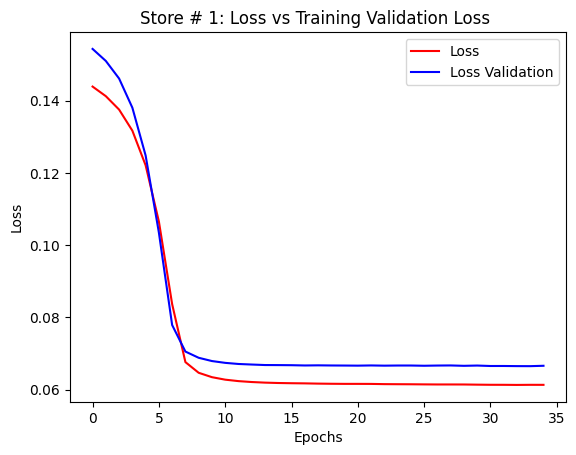

In [98]:
# Set up function to train just store #1
trainAllStores(model, 2, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length)

12/12 [==============================] - 0s 2ms/step


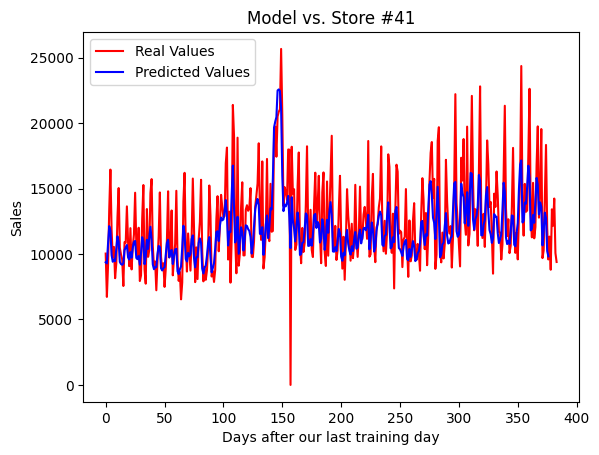

In [99]:
# Use model to predict store #41
store_num = 41
predictOneStore(model, store_num, start_bounds, middle_bounds)

Here I will train the model on 20 additional stores and predict store #41 again.

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0613 - val_loss: 0.0667
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0612 - val_loss: 0.0665
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0612 - val_loss: 0.0665
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0612 - val_loss: 0.0665
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0612 - val_loss: 0.0667
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0612 - val_loss: 0.0665
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0611 - val_loss: 0.0664
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0611 - val_loss: 0.0664
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0611 - val_loss: 0.0664
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0610 - val_loss: 0.0664
Epoch 11/35
24/24 

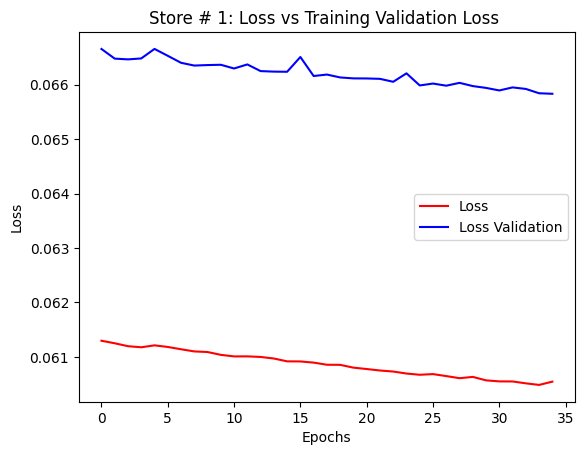

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0634 - val_loss: 0.0169
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0184
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0186
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0181
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0176
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0197
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0196
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0191
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0207
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0193
Epoch 11/35
24/24 

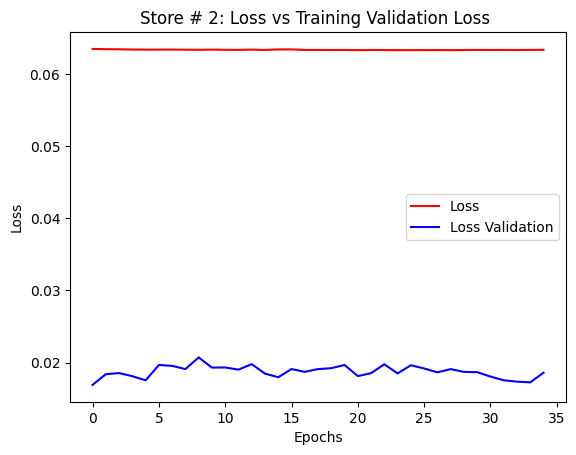

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0777
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0778
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0780
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0780
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0778
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0778
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0777
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0780
Epoch 9/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0568 - val_loss: 0.0779
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0778
Epoch 11/35
24/24 [

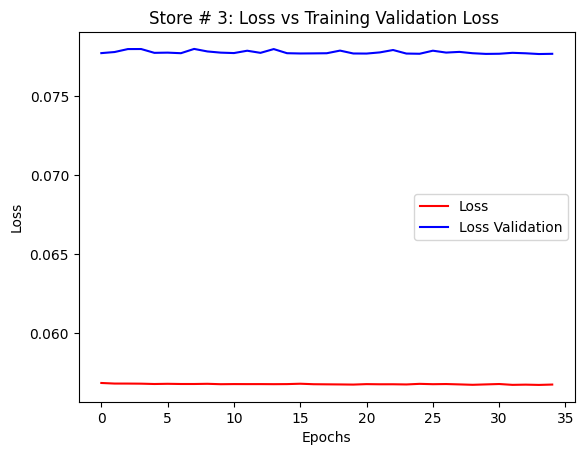

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0476 - val_loss: 0.0724
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0724
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0724
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0723
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 11/35
24/24 

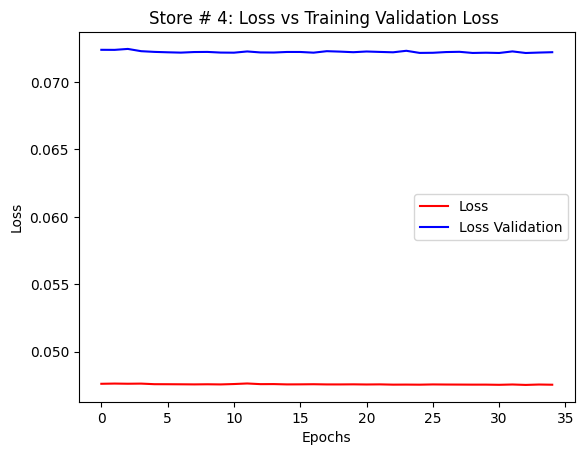

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0718
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0716
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0715
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0718
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0715
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0715
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0714
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0716
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0714
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0451 - val_loss: 0.0715
Epoch 11/35
24/24 [

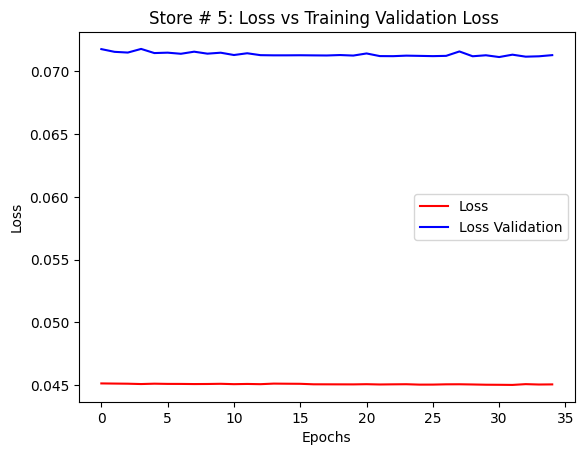

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0522 - val_loss: 0.0661
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0522 - val_loss: 0.0660
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0522 - val_loss: 0.0660
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0521 - val_loss: 0.0659
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0522 - val_loss: 0.0659
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0521 - val_loss: 0.0659
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0521 - val_loss: 0.0659
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0521 - val_loss: 0.0659
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0521 - val_loss: 0.0659
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0521 - val_loss: 0.0660
Epoch 11/35
24/24 [

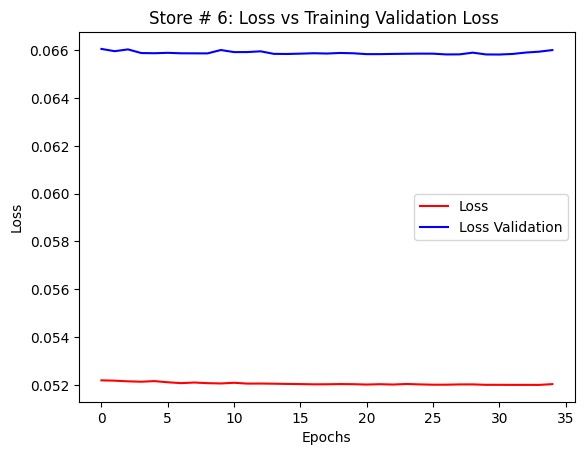

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0593 - val_loss: 0.0798
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0593 - val_loss: 0.0797
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0594 - val_loss: 0.0797
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0593 - val_loss: 0.0797
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0592 - val_loss: 0.0796
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0592 - val_loss: 0.0795
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0592 - val_loss: 0.0795
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0592 - val_loss: 0.0795
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0592 - val_loss: 0.0795
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0591 - val_loss: 0.0794
Epoch 11/35
24/24 [

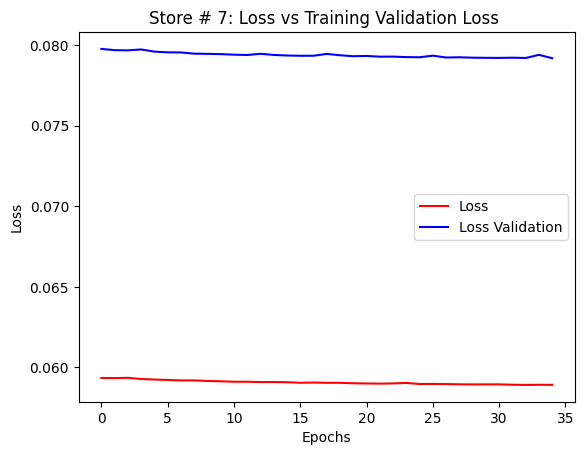

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0612 - val_loss: 0.0793
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0613 - val_loss: 0.0793
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0611 - val_loss: 0.0792
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0610 - val_loss: 0.0793
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0611 - val_loss: 0.0792
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0610 - val_loss: 0.0791
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0610 - val_loss: 0.0791
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0610 - val_loss: 0.0791
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0610 - val_loss: 0.0791
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0609 - val_loss: 0.0792
Epoch 11/35
24/24 [

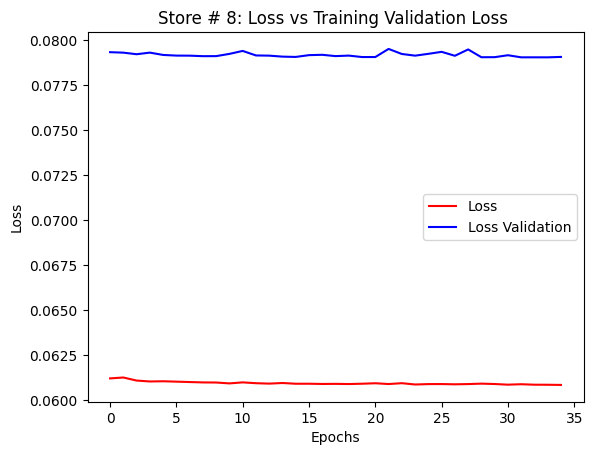

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0358 - val_loss: 0.0601
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0602
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0358 - val_loss: 0.0601
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0601
Epoch 11/35
24/24 [

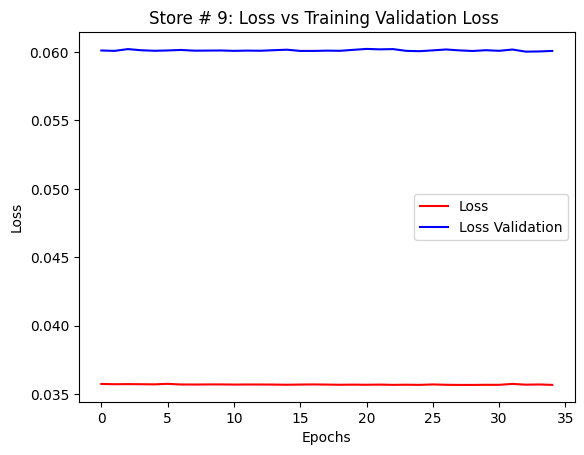

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0669 - val_loss: 0.0305
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0668 - val_loss: 0.0305
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0668 - val_loss: 0.0306
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0669 - val_loss: 0.0309
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0668 - val_loss: 0.0310
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0668 - val_loss: 0.0311
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0667 - val_loss: 0.0308
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0668 - val_loss: 0.0309
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0667 - val_loss: 0.0311
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0667 - val_loss: 0.0313
Epoch 11/35
24/24 [

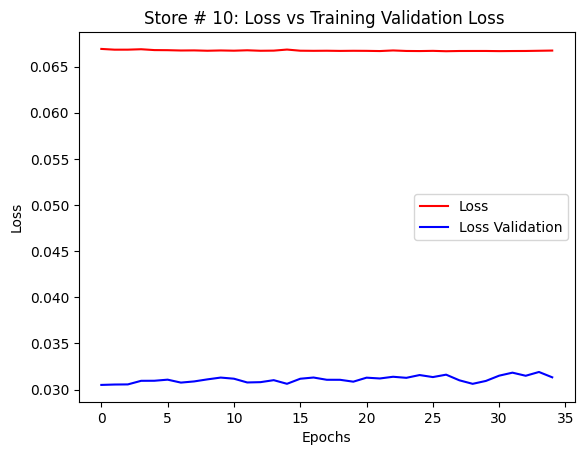

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0591 - val_loss: 0.0725
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0590 - val_loss: 0.0728
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0590 - val_loss: 0.0724
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0590 - val_loss: 0.0723
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0590 - val_loss: 0.0723
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0590 - val_loss: 0.0723
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0589 - val_loss: 0.0723
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0590 - val_loss: 0.0723
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0589 - val_loss: 0.0723
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0589 - val_loss: 0.0724
Epoch 11/35
24/24 [

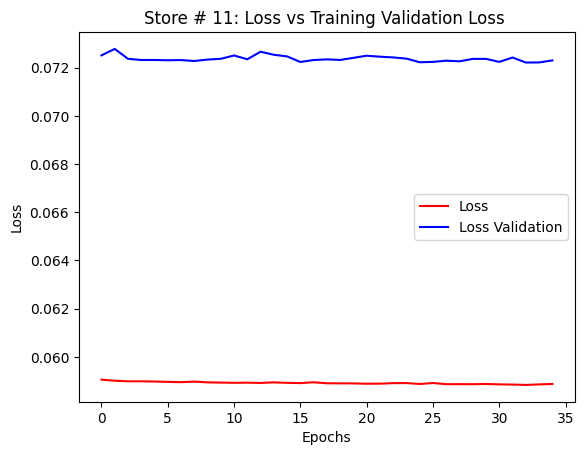

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0256 - val_loss: 0.0811
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0249 - val_loss: 0.0798
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0247 - val_loss: 0.0786
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0247 - val_loss: 0.0784
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0779
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0245 - val_loss: 0.0776
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0245 - val_loss: 0.0769
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0768
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0765
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0764
Epoch 11/35
24/24 [

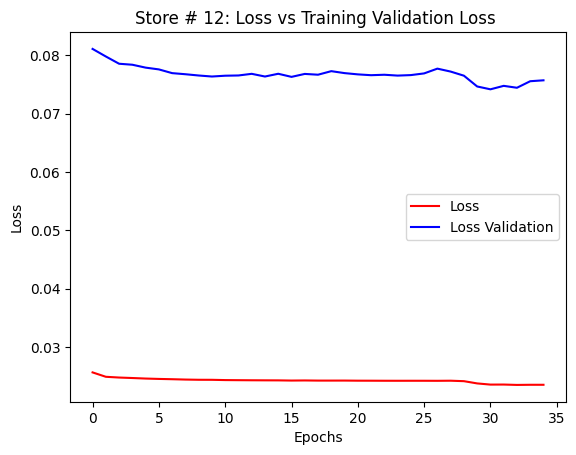

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0370 - val_loss: 0.0658
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0370 - val_loss: 0.0658
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0658
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0659
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0657
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0658
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0657
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0658
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0659
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0661
Epoch 11/35
24/24 

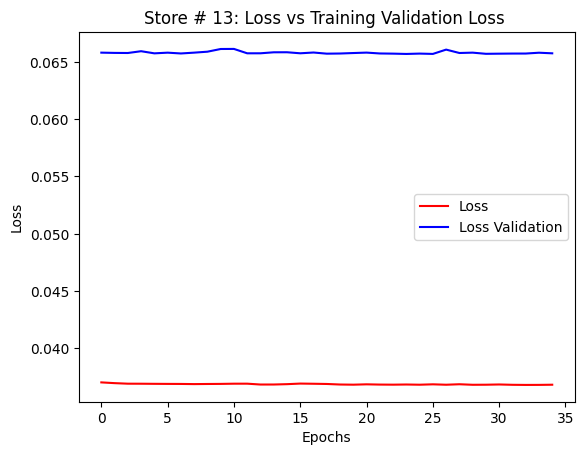

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0689
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0690
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0689
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0689
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0689
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0518 - val_loss: 0.0689
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0691
Epoch 8/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0519 - val_loss: 0.0690
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0518 - val_loss: 0.0689
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0519 - val_loss: 0.0689
Epoch 11/35
24/24 [

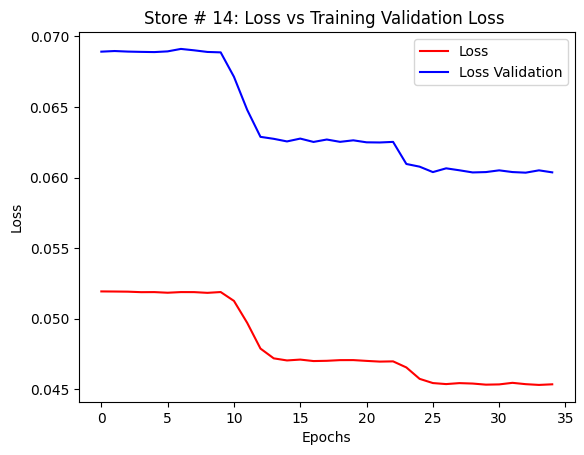

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0311 - val_loss: 0.0652
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0311 - val_loss: 0.0661
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0652
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0654
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0655
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0656
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0309 - val_loss: 0.0651
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0309 - val_loss: 0.0655
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0309 - val_loss: 0.0652
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0309 - val_loss: 0.0656
Epoch 11/35
24/24 [

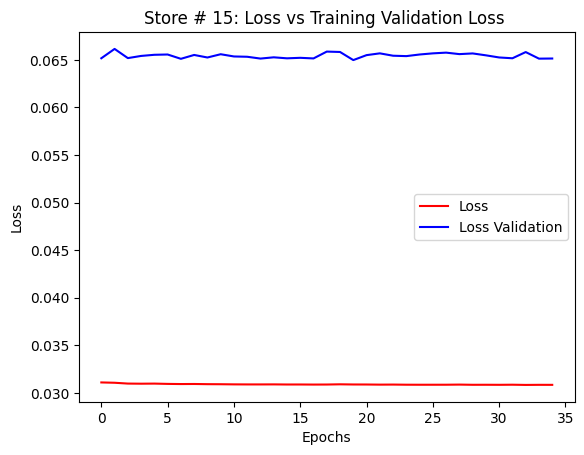

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0486 - val_loss: 0.0408
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0477 - val_loss: 0.0408
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0476 - val_loss: 0.0408
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0475 - val_loss: 0.0407
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0474 - val_loss: 0.0407
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0474 - val_loss: 0.0407
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0474 - val_loss: 0.0407
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0473 - val_loss: 0.0407
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0473 - val_loss: 0.0407
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0473 - val_loss: 0.0407
Epoch 11/35
24/24 

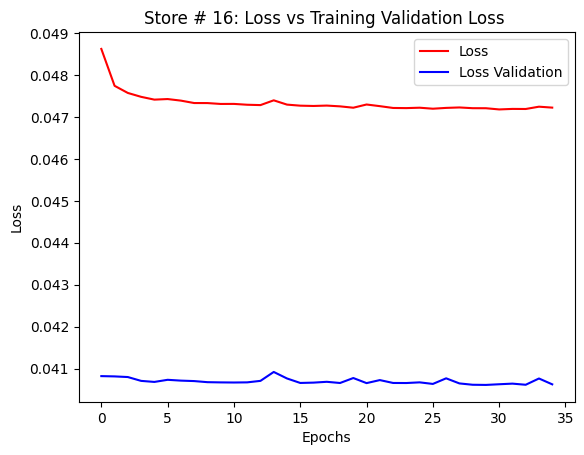

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0521
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0521
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0521
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0521
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0304 - val_loss: 0.0521
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0304 - val_loss: 0.0521
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0521
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0304 - val_loss: 0.0521
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0520
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0304 - val_loss: 0.0521
Epoch 11/35
24/24 [

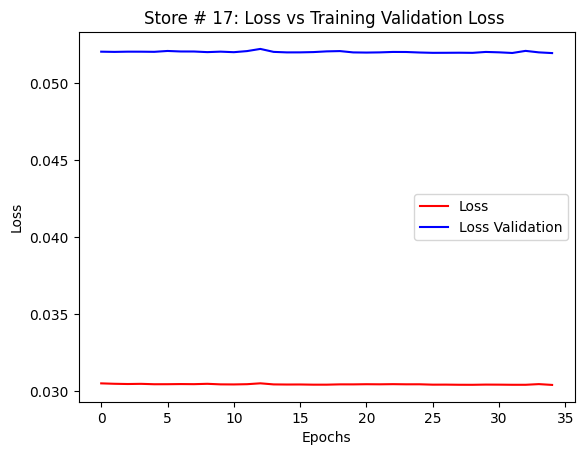

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0390 - val_loss: 0.0339
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0389 - val_loss: 0.0341
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0391 - val_loss: 0.0340
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0390 - val_loss: 0.0338
Epoch 5/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0390 - val_loss: 0.0338
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0390 - val_loss: 0.0339
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0389 - val_loss: 0.0338
Epoch 8/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0389 - val_loss: 0.0339
Epoch 9/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0389 - val_loss: 0.0338
Epoch 10/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0390 - val_loss: 0.0338
Epoch 11/35
24/24 [

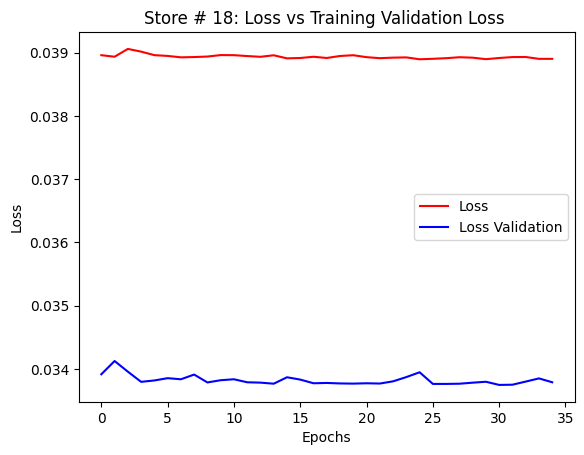

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0408 - val_loss: 0.0620
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0408 - val_loss: 0.0620
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0620
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0621
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0620
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0619
Epoch 7/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0407 - val_loss: 0.0621
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0621
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0406 - val_loss: 0.0619
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0406 - val_loss: 0.0620
Epoch 11/35
24/24 [

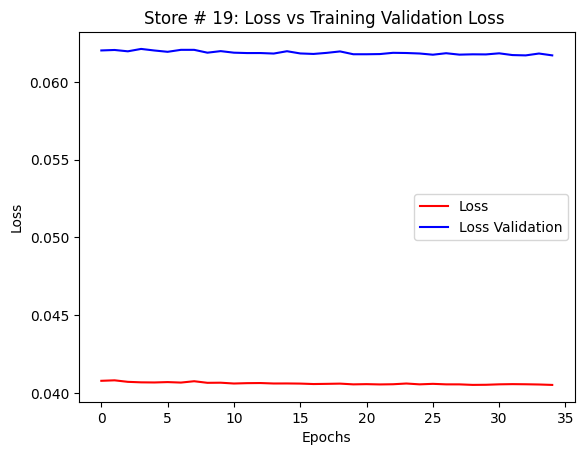

In [100]:
# Train on all stores up to num_stores
trainAllStores(model, num_stores, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length)

12/12 [==============================] - 0s 2ms/step


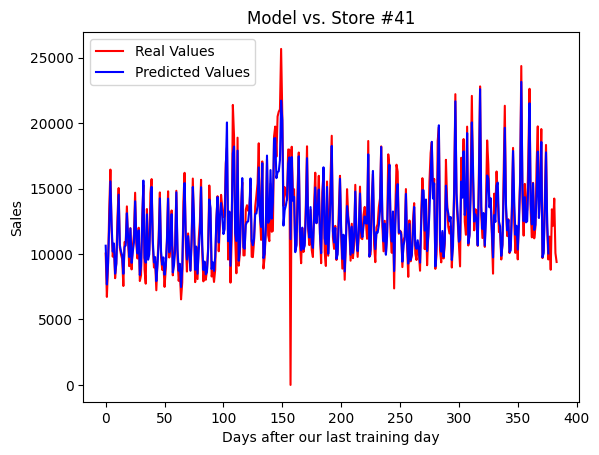

In [101]:
# Show model predictions for all stores up to num_stores
predictOneStore(model, store_num, start_bounds, middle_bounds)

We can see that, when trained on more stores, the model is able to better capture general trends in the data. In the initial test where we only trained one store #1, the model was not able to capture the smaller intricate ups and downs of the data. In addition to that, we also see that the local peak values are closer to the real local peak values and the same goes for the local minimums, generally. We can also see that the model loses sight of the very big outlier cases, as such for the data point around day 150. In our first prediction, it was able to get much closer to that specific peak value.

We also see that in this model, the loss vs. validation loss is very high. I beleive, this is due to the simplicity of the data being given to the model. Since my model is only trained on date and sales for that date, it could lead to the high difference between the two loss values shown.